# 1. Gaussian Distributions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import norm, multivariate_normal
import math

## 1.2 Univariate Gaussian

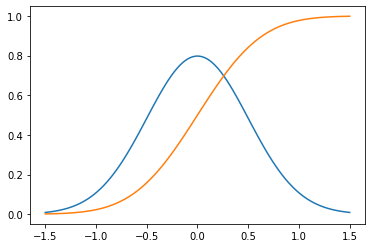

In [2]:
mu = 0
variance = 0.25
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, norm.pdf(x, mu, sigma))
plt.plot(x, norm.cdf(x, mu, sigma))
plt.rcParams["figure.figsize"] = (7, 5)
plt.show()

## 1.2 Multivariate Gaussian

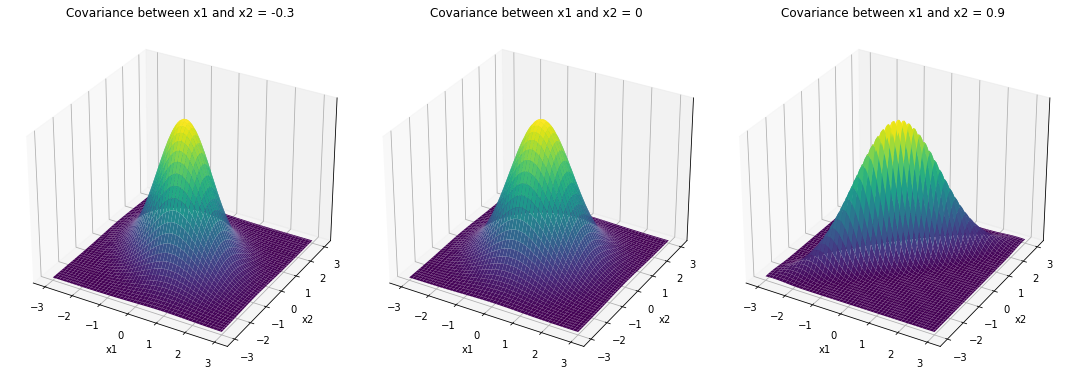

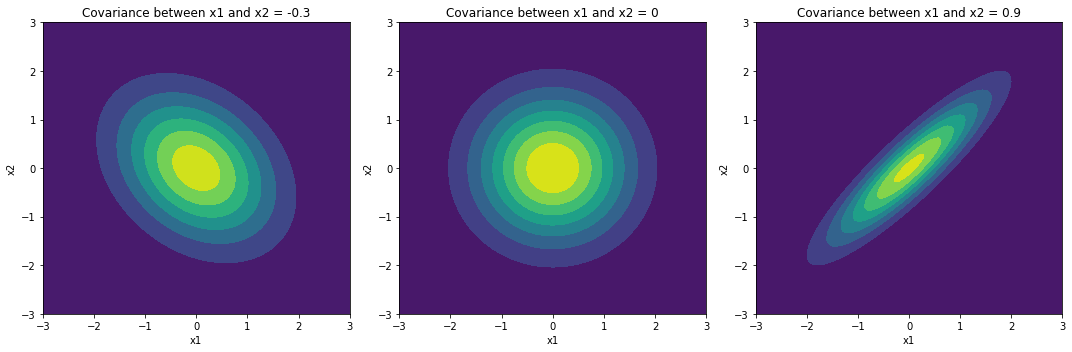

In [11]:
fig = plt.figure()
 
# Initializing the random seed
random_seed = 1000
 
# List containing the variance and covariance values
cov_val = [-0.3, 0, 0.9]
 
# Setting mean of the distributino to be at (0,0)
mean = np.array([0,0])
 
# Storing density function values for further analysis
pdf_list = []
 
# Iterating over different covariance values
for idx, val in enumerate(cov_val):
     
    # Initializing the covariance matrix
    cov = np.array([[1, val], [val, 1]])
     
    # Generating a Gaussian bivariate distribution with given mean and covariance matrix
    distr = multivariate_normal(cov = cov, mean = mean, seed = random_seed)
     
    # Generating a meshgrid complacent with the 3-sigma boundary
    mean_1, mean_2 = mean[0], mean[1]
    sigma_1, sigma_2 = cov[0,0], cov[1,1]
     
    x = np.linspace(-3*sigma_1, 3*sigma_1, num=100)
    y = np.linspace(-3*sigma_2, 3*sigma_2, num=100)
    X, Y = np.meshgrid(x,y)
     
    # Generating the density function for each point in the meshgrid
    pdf = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            pdf[i,j] = distr.pdf([X[i,j], Y[i,j]])
     
    # Plotting the density function values
    key = 131 + idx
    ax = fig.add_subplot(key, projection = '3d')
    ax.plot_surface(X, Y, pdf, cmap = 'viridis')
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(f'Covariance between x1 and x2 = {val}')
    pdf_list.append(pdf)
    ax.axes.zaxis.set_ticks([])
 
plt.tight_layout()
plt.rcParams["figure.figsize"] = (15, 5)
plt.show()
 
# Plotting contour plots
for idx, val in enumerate(pdf_list):
    plt.subplot(1,3,idx+1)
    plt.contourf(X, Y, val, cmap='viridis')
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(f'Covariance between x1 and x2 = {cov_val[idx]}')
plt.tight_layout()
plt.rcParams["figure.figsize"] = (15, 5)
plt.show()

# 2. Gaussian Process

## 2.1 Make Artificial Data

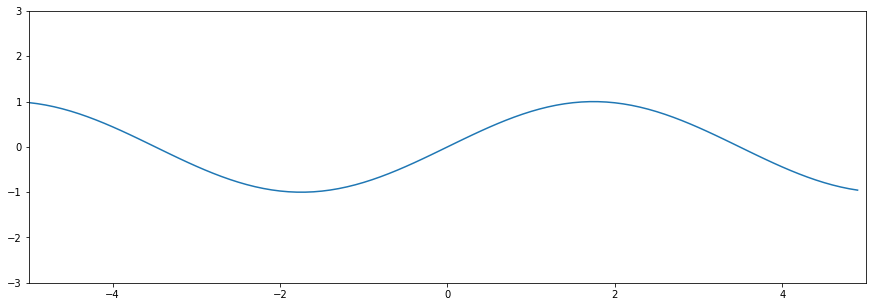

In [4]:
# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()
#f = lambda x: (0.25*(x**2)).flatten()
x = np.arange(-5, 5, 0.1)

plt.plot(x, f(x))
plt.axis([-5, 5, -3, 3])
plt.rcParams["figure.figsize"] = (5, 4)
plt.show()

# Sample some input points and noisy versions of the function evaluated at
# these points. 
N = 20         # number of existing observation points (training points).
n = 200        # number of test points.
s = 0.00005    # noise variance.

# N training points
X = np.random.uniform(-5, 5, size=(N,1))      
y = f(X) + s*np.random.randn(N)

# points we're going to make predictions at.
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

## 2.2 Define Kernel

In [5]:
# Define the RBF kernel
def kernel(a, b):
    kernelParameter_l = 0.1
    kernelParameter_sigma = 1.0
    sqdist = np.sum(a**2,axis=1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    # np.sum( ,axis=1) means adding all elements columnly 
    # reshap(-1, 1) adds one dimension to make (n,) become (n,1)
    return kernelParameter_sigma*np.exp(-.5 * (1/kernelParameter_l) * sqdist)

## 2.3 GP Algorithm

In [6]:
K = kernel(X, X)
L = np.linalg.cholesky(K + s*np.eye(N))     

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest))   
mu = np.dot(Lk.T, np.linalg.solve(L, y))    

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest)                  
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)   
s = np.sqrt(s2)

## 2.4 Plots

### 2.4.1. Prior Samples

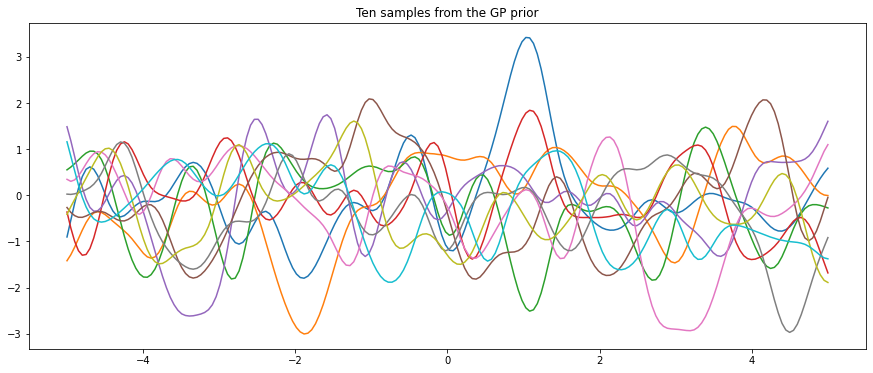

In [10]:
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n))
f_prior = np.dot(L, np.random.normal(size=(n,10)))
plt.figure(2)
plt.clf()
plt.plot(Xtest, f_prior)
plt.title('Ten samples from the GP prior')
plt.rcParams["figure.figsize"] = (15, 6)
plt.show()

### 2.4.2 Posterior Samples

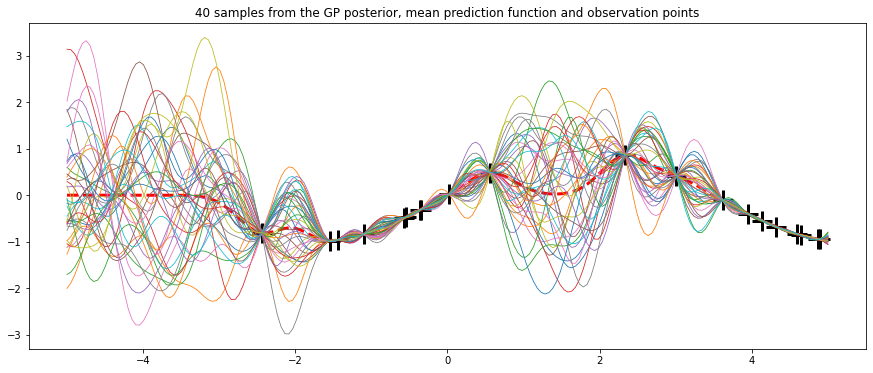

In [8]:
# Draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,40)))  
plt.figure(3)
plt.clf()
plt.plot(X, y, 'k+', markersize=20, markeredgewidth=3)
plt.plot(Xtest, mu, 'r--', linewidth=3)
plt.plot(Xtest, f_post, linewidth=0.8)
plt.title('40 samples from the GP posterior, mean prediction function and observation points')
plt.rcParams["figure.figsize"] = (15, 6)
plt.show()

### 2.4.3 Predictive Mean with Confidence Interval

<Figure size 1080x432 with 0 Axes>

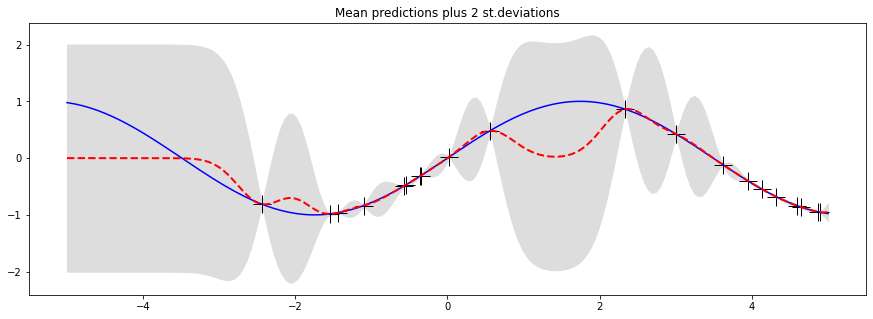

In [9]:
# Posterior mean
plt.figure(1)
plt.clf()
plt.figure(figsize=(15,5))
plt.plot(X, y, 'k+', ms=18)
plt.plot(Xtest, f(Xtest), 'b-')
plt.gca().fill_between(Xtest.flat, mu-2*s, mu+2*s, color="#dddddd")
plt.plot(Xtest, mu, 'r--', lw=2)
plt.title('Mean predictions plus 2 st.deviations')
plt.show()